# Testing VGG16 network (variation 1)

In this notebook I use the data explored and processed in notebooks 1-3 to see how well the pretrained VGG16 model works as a classifier.

In [1]:
import os
import time
import pickle

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import metrics

#TODO implement this function
from cars_utils import time_save_model, plot_metrics

Using TensorFlow backend.


### BASIC  IMAGE, AND BATCH SETUP

In [2]:
# Image dimensions:
IMG_WIDTH, IMG_HEIGHT = 100*2, 75*2

BASE = os.getcwd()
SAVE_DIR = os.path.join(BASE, 'data', 'VGG16')
BASE = os.path.join(BASE, 'data', 'cars_dataset', 'keras')

### Settings for full training
TRAIN_DATA_DIR = os.path.join(BASE, 'train')
VALIDATION_DATA_DIR = os.path.join(BASE, 'validation')
NB_CLASSES = 196
NB_TRAIN_SAMPLES = 11329
NB_VALIDATION_SAMPLES = 2428
BATCH_SIZE = 64

### Settings for fast checking
# TRAIN_DATA_DIR = os.path.join(BASE, 'fast', 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'fast', 'validation')
# NB_CLASSES = 196
# NB_TRAIN_SAMPLES = NB_CLASSES*2
# NB_VALIDATION_SAMPLES = NB_CLASSES
# BATCH_SIZE = 4

### Settings for faster checking
# TRAIN_DATA_DIR = os.path.join(BASE, 'fast_v2', 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'fast_v2', 'validation')
# NB_CLASSES = 6
# NB_TRAIN_SAMPLES = NB_CLASSES*2
# NB_VALIDATION_SAMPLES = NB_CLASSES
# BATCH_SIZE = 4

if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=INPUT_SHAPE)

In [4]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512*4, activation='relu'))
model.add(Dense(512*4, activation='relu'))
model.add(Dense(NB_CLASSES, activation='softmax'))

conv_base.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 32
This is the number of trainable weights after freezing the conv base: 6


In [5]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 11329 images belonging to 196 classes.
Found 2428 images belonging to 196 classes.


Define custom metrics to measure

In [7]:
def top_3_acc(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[metrics.categorical_accuracy, top_3_acc])

In [9]:
EPOCHS = 100
start_time = time.time()
summary = model.fit_generator(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=NB_VALIDATION_SAMPLES // BATCH_SIZE)
end_time = time.time()

Epoch 1/100
177/177 [==============================] - 192s 1s/step - loss: 5.2764 - categorical_accuracy: 0.0117 - top_3_acc: 0.0312 - val_loss: 4.9713 - val_categorical_accuracy: 0.0131 - val_top_3_acc: 0.0397
Epoch 2/100
177/177 [==============================] - 171s 964ms/step - loss: 4.8959 - categorical_accuracy: 0.0245 - top_3_acc: 0.0688 - val_loss: 4.6117 - val_categorical_accuracy: 0.0372 - val_top_3_acc: 0.0942
Epoch 3/100
177/177 [==============================] - 170s 962ms/step - loss: 4.6671 - categorical_accuracy: 0.0413 - top_3_acc: 0.0976 - val_loss: 4.5716 - val_categorical_accuracy: 0.0435 - val_top_3_acc: 0.1026
Epoch 4/100
177/177 [==============================] - 169s 955ms/step - loss: 4.5706 - categorical_accuracy: 0.0450 - top_3_acc: 0.1105 - val_loss: 4.3612 - val_categorical_accuracy: 0.0574 - val_top_3_acc: 0.1402
Epoch 5/100
177/177 [==============================] - 170s 959ms/step - loss: 4.4379 - categorical_accuracy: 0.0600 - top_3_acc: 0.1344 - val_

Epoch 39/100
177/177 [==============================] - 161s 912ms/step - loss: 3.8259 - categorical_accuracy: 0.1164 - top_3_acc: 0.2598 - val_loss: 3.8847 - val_categorical_accuracy: 0.1170 - val_top_3_acc: 0.2534
Epoch 40/100
177/177 [==============================] - 164s 927ms/step - loss: 3.8038 - categorical_accuracy: 0.1262 - top_3_acc: 0.2654 - val_loss: 3.8787 - val_categorical_accuracy: 0.1153 - val_top_3_acc: 0.2551
Epoch 41/100
177/177 [==============================] - 163s 920ms/step - loss: 3.7952 - categorical_accuracy: 0.1278 - top_3_acc: 0.2670 - val_loss: 4.0891 - val_categorical_accuracy: 0.1060 - val_top_3_acc: 0.2285
Epoch 42/100
177/177 [==============================] - 164s 929ms/step - loss: 3.8017 - categorical_accuracy: 0.1212 - top_3_acc: 0.2729 - val_loss: 3.9064 - val_categorical_accuracy: 0.1178 - val_top_3_acc: 0.2513
Epoch 43/100
177/177 [==============================] - 164s 928ms/step - loss: 3.7668 - categorical_accuracy: 0.1305 - top_3_acc: 0.274

Epoch 77/100
177/177 [==============================] - 163s 922ms/step - loss: 3.6100 - categorical_accuracy: 0.1548 - top_3_acc: 0.3104 - val_loss: 4.0318 - val_categorical_accuracy: 0.1182 - val_top_3_acc: 0.2589
Epoch 78/100
177/177 [==============================] - 162s 918ms/step - loss: 3.6324 - categorical_accuracy: 0.1502 - top_3_acc: 0.3043 - val_loss: 3.9855 - val_categorical_accuracy: 0.1170 - val_top_3_acc: 0.2690
Epoch 79/100
177/177 [==============================] - 161s 912ms/step - loss: 3.5980 - categorical_accuracy: 0.1517 - top_3_acc: 0.3188 - val_loss: 3.9807 - val_categorical_accuracy: 0.1178 - val_top_3_acc: 0.2597
Epoch 80/100
177/177 [==============================] - 163s 922ms/step - loss: 3.6013 - categorical_accuracy: 0.1572 - top_3_acc: 0.3092 - val_loss: 3.9261 - val_categorical_accuracy: 0.1229 - val_top_3_acc: 0.2855
Epoch 81/100
177/177 [==============================] - 161s 910ms/step - loss: 3.6074 - categorical_accuracy: 0.1459 - top_3_acc: 0.310

In [10]:
time_save_model(model,
                summary.history,
                start_time, end_time,
                '1_VGG16_0_100',
                SAVE_DIR)

traing took: 273.0 minutes


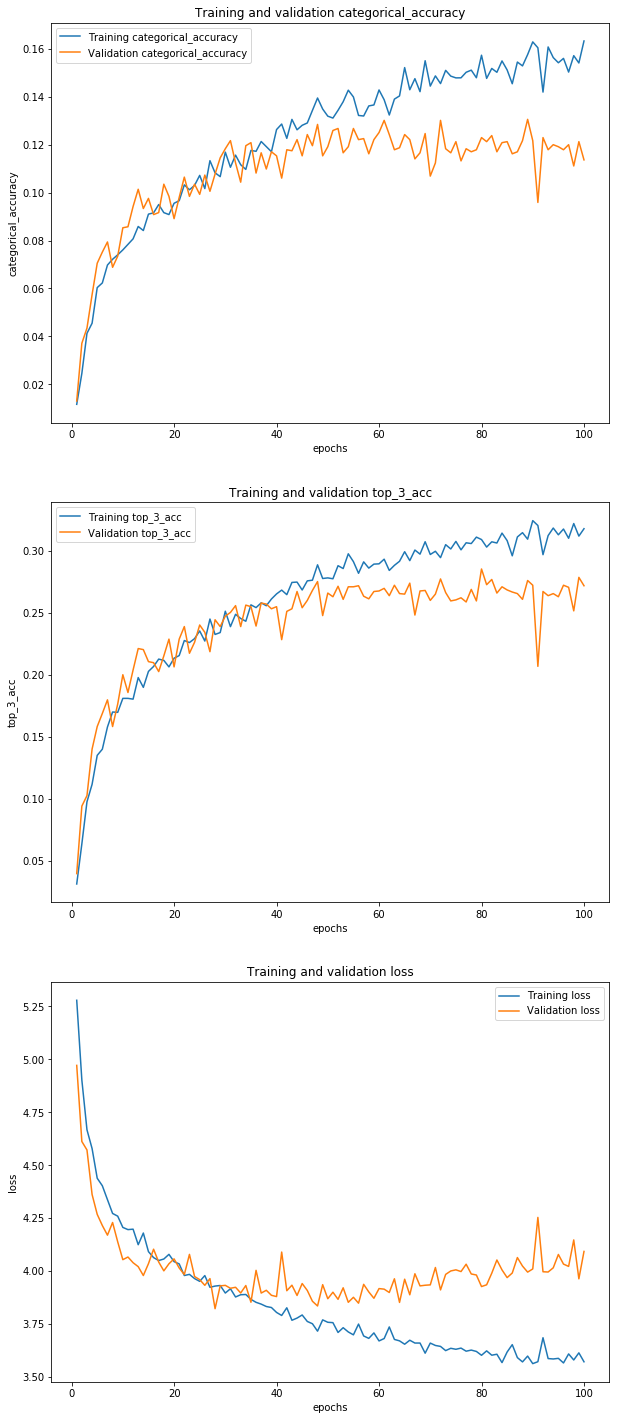

In [12]:
key_list = ['categorical_accuracy',
            'top_3_acc',
            'loss']
show = plot_metrics(summary.history, key_list)